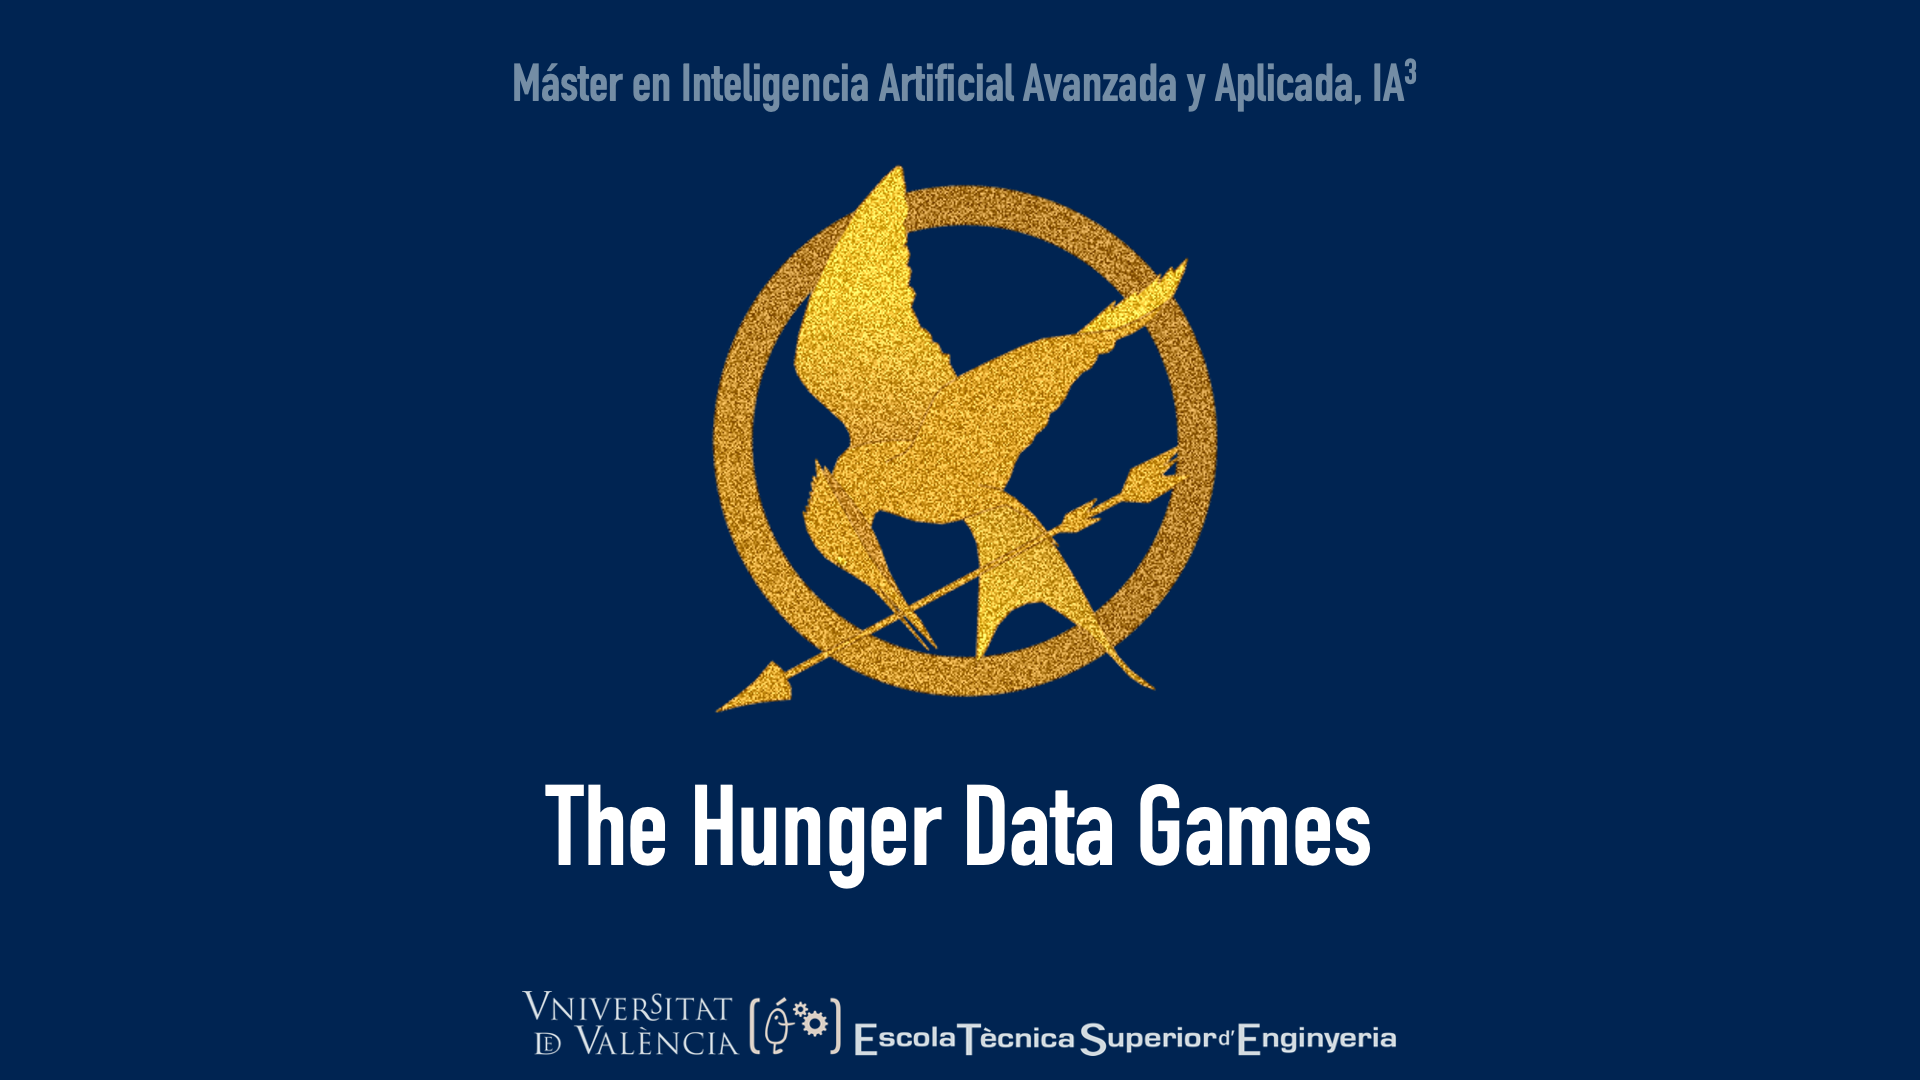

Wellcome to the first hunger data games!!! You have been selected as tributes from your sectors. In this edition you will be facing each other in a classification competition. The dataset you will be facing is this one:



A few recommendations for you to solve the exercise. Remember the different types of algorithm that we have studied and follow a natural path in building the exercise. Commence using a single estimator and try to build a bagging estimator.

For the evaluation metric check this webpage:

https://scikit-learn.org/stable/modules/model_evaluation.html

Specially check those called balanced_accuracy and f1_micro.

Finally the submission of the exercise must be a model file with the name of your team (find one which is cool I will add the coolness of the name to the final grade). 

Check this webpage for saving the model: https://scikit-learn.org/stable/modules/model_persistence.html

One more thing I will evaluate using the np.random.seed(123) use it for training your model.

In case that a preprocessing of data is performed include a class in the notebook which transforms the original input to your desired one.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [2]:
#Definition of functions used to compare the performance of the models.

def metric_summary(model, X_val, y_val, name_model=None):
    '''Metrics summary'''
    if name_model == None: name_model = type(model).__name__

    summary_score = np.array([
        '%0.4f'%metrics.roc_auc_score(y_val, model.predict_proba(X_val), average='macro', multi_class='ovr'),
        '%0.4f'%metrics.f1_score(y_val, model.predict(X_val), average='micro'),
        '%0.4f'%metrics.balanced_accuracy_score(y_val, model.predict(X_val))])
    
    df = pd.DataFrame(summary_score, columns=[name_model], index=['roc_auc', 'f1_micro', 'balanced_accuracy'])
    return df;


def roc_summary(model, X_test, y_test, name_model=None, class_i=None):
    '''ROC AUC summary'''
    if name_model == None: name_model = type(model).__name__
    
    # Binarize the output
    class_name = list(set(y_test[y_test.columns[0]]))
    n_classes = len(class_name)
    y_test = label_binarize(y_test, classes=class_name)
    
    if hasattr(model, 'decision_function') == True: y_score = model.decision_function(X_test)
    else: y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_name)):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    if class_i==None:
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"], linestyle="-", linewidth=2,
        label="(AUC: {0:0.4f})".format(roc_auc["macro"])+" "+name_model)
    else:
        plt.plot(fpr[class_i], tpr[class_i], linestyle="-", linewidth=1,
        label="(AUC: {0:0.4f})".format(roc_auc[class_i])+" "+name_model+" class "+str(class_name[class_i]))
    return;

## Load the data

In [3]:
url = "https://raw.githubusercontent.com/CuadraAlconero/IDAL_IA3_CuadraAlconero/main/glass.csv"
dataframe = pd.read_csv(url, header=0)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

In [4]:
dataframe.head(10)

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron,type_of_glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


The target variable is type_of_glass

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   refractive_index  214 non-null    float64
 1   sodium            214 non-null    float64
 2   magnesium         214 non-null    float64
 3   aluminum          214 non-null    float64
 4   silicon           214 non-null    float64
 5   potassium         214 non-null    float64
 6   calcium           214 non-null    float64
 7   barium            214 non-null    float64
 8   iron              214 non-null    float64
 9   type_of_glass     214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
dataframe.describe()

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron,type_of_glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


According to the described info, all values seem inside the standard range, except for the std deviation values of magnesium and calcium. These two values seem to be a bit high although they cannot be considered a sign of outlier since the distance is not so high. 

Now the data needs normalization. Let's start by removing the Na values.

## Looking for outliers

In [7]:
dataframe.dropna(inplace = True)

<b><u>Looking for outliers in our dataframe</u></b>

<FONT COLOR="blue">Searching for outliers by using the IQR technique</FONT>

In [8]:
# Calculate iqr for every variable

df = dataframe.iloc[:, :-1]
describe_df = df.describe()
iqr = describe_df.loc["75%"] - describe_df.loc["25%"]
iqr

refractive_index    0.002635
sodium              0.917500
magnesium           1.485000
aluminum            0.440000
silicon             0.807500
potassium           0.487500
calcium             0.932500
barium              0.000000
iron                0.100000
dtype: float64

In [9]:
# Upper and lower bounds
upper_bound = describe_df.loc["75%"]+1.5*iqr
lower_bound = describe_df.loc["25%"]-1.5*iqr

In [10]:
# Upper Outliers detected
boolean_index = df > upper_bound
outliers = boolean_index.sum(axis=1)
boolean_index2 = outliers > 0
df.loc[boolean_index2]

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.00,0.26
32,1.51775,12.85,3.48,1.23,72.97,0.61,8.56,0.09,0.22
36,1.51909,13.89,3.53,1.32,71.81,0.51,8.78,0.11,0.00
44,1.51786,12.73,3.43,1.19,72.95,0.62,8.76,0.00,0.30
47,1.52667,13.99,3.70,0.71,71.57,0.02,9.82,0.00,0.10
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.00
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.00
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.00
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.00


In [11]:
# Who's the outlier related to the upper bound?
boolean_index.loc[boolean_index2]

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron
5,False,False,False,False,False,False,False,False,True
32,False,False,False,False,False,False,False,True,False
36,False,False,False,False,False,False,False,True,False
44,False,False,False,False,False,False,False,False,True
47,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
209,False,False,False,True,False,False,False,True,False
210,False,False,False,False,False,False,False,True,False
211,False,False,False,False,False,False,False,True,False
212,False,False,False,False,False,False,False,True,False


Barium seems to have many outliers located over the upper bound. However, not all of the values are outliers. Since we have a quite small dataset, we decided not to remove any of the features nor full rows. These variable also provides information and we cannot just ignore it.

In [12]:
# Lower outliers detected
low_boolean_index = df < lower_bound
low_outliers = low_boolean_index.sum(axis=1)
low_boolean_index2 = low_outliers > 0
df.loc[low_boolean_index2]

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron
21,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.00,0.00
38,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.00,0.00
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.00,0.00
50,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.00,0.16
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.00,0.31
103,1.52725,13.80,3.15,0.66,70.57,0.08,11.64,0.00,0.00
105,1.52475,11.45,0.00,1.88,72.19,0.81,13.24,0.00,0.34
106,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28
107,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.00,0.24
110,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.00,0.00


In [13]:
# Who's the outlier related to the lower bound?
low_boolean_index.loc[low_boolean_index2]

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron
21,False,False,False,True,False,False,False,False,False
38,False,False,False,True,False,False,False,False,False
39,False,False,False,True,False,False,False,False,False
50,False,False,False,True,False,False,False,False,False
56,True,False,False,False,False,False,False,False,False
103,False,False,False,False,True,False,False,False,False
105,False,True,False,False,False,False,False,False,False
106,False,True,False,False,True,False,False,False,False
107,False,False,False,False,True,False,False,False,False
110,False,True,False,False,False,False,False,False,False


Regarding the lower bound, we can find outliers in almost every column, the results are not concentrated in only one or two variables, but spread over allmost all of them. As we mentioned before, it is not worthy to remove a whole variable nor a whole row since our dataset is quite small. In addition the numeric values do not show big differences which could affect dramatically to our results.

<FONT COLOR="blue">Searching for outliers by using the Isolation Forest model</FONT>

In [14]:
from sklearn.ensemble import IsolationForest

#Building the model with the IsolationForest method from Sklearn
iso_forest = IsolationForest(n_estimators=500)
iso_forest.fit(df)

IsolationForest(n_estimators=500)

In [15]:
# Using the predict method, we get an unidimensional array where 1 shows the outlier
# and -1 shows the normal values
iso_forest.predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1])

In [16]:
# Using score_samples you get an score for each value. When the score is negative, it means the value has been assessed as normal.
iso_forest.score_samples(df)


array([-0.42835753, -0.35476108, -0.35513333, -0.33531992, -0.33799803,
       -0.3907386 , -0.34163329, -0.35197488, -0.36307966, -0.34684545,
       -0.39296595, -0.33487782, -0.39052062, -0.36041657, -0.34397712,
       -0.33963569, -0.34447029, -0.41969342, -0.37264672, -0.35178892,
       -0.35661516, -0.45962681, -0.33428979, -0.33342415, -0.33843234,
       -0.33488213, -0.33105063, -0.33385312, -0.34398027, -0.33026675,
       -0.35749371, -0.3449613 , -0.38453992, -0.36339052, -0.33623984,
       -0.34372387, -0.38487807, -0.33674614, -0.41832153, -0.41832153,
       -0.3428156 , -0.34196635, -0.33110424, -0.40198458, -0.3883019 ,
       -0.35286526, -0.35639795, -0.47213957, -0.40063045, -0.35125874,
       -0.45462294, -0.36433734, -0.34496554, -0.3443155 , -0.36246468,
       -0.42004598, -0.45459143, -0.33500625, -0.34470659, -0.35146663,
       -0.36038738, -0.44922317, -0.41159031, -0.42177419, -0.39882912,
       -0.37612773, -0.40895961, -0.40878226, -0.40763472, -0.41

By using the "predict" metod, a few outliers have been detected. However, while using the "score_samples" method, no outliers have arisen. Taking into account we may be losing information if we remove the outliers resulting from the "predict" method, and considering that our dataset is quite small, we decided not to remove any feature nor observations. 

## Preprocess

In [17]:
# Standarization with Min-Max Scaling

X = df
min_max_scl = MinMaxScaler()
X_norm = min_max_scl.fit_transform(X)
X_norm_df = pd.DataFrame(X_norm)
X_norm_df.head()

,0,1,2,3,4,5,6,7,8
0,0.432836,0.437594,1.000000,0.252336,0.351786,0.009662,0.308550,0.0,0.0
1,0.283582,0.475188,0.801782,0.333333,0.521429,0.077295,0.223048,0.0,0.0
2,0.220808,0.421053,0.790646,0.389408,0.567857,0.062802,0.218401,0.0,0.0
3,0.285777,0.372932,0.821826,0.311526,0.500000,0.091787,0.259294,0.0,0.0
4,0.275241,0.381955,0.806236,0.295950,0.583929,0.088567,0.245353,0.0,0.0


In [18]:
class Transform:
  def __init__(self,df):
    self.df = df
  def transform(self):
    min_max_scl = MinMaxScaler()
    X_norm = pd.DataFrame(min_max_scl.fit_transform(self.df.iloc[:,0:-1]), columns=dataframe.iloc[:,0:-1].columns)
    Y = self.df.iloc[:,-1:]
    return X_norm,Y

transform = Transform(dataframe)
X,Y = transform.transform()

In [19]:
print(type(X))
print(X.shape)
print(type(Y))
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
(214, 9)
<class 'pandas.core.frame.DataFrame'>
(214, 1)


## Train the model
### Shuffle and split training and test sets


In [20]:
#After standarization, we proceed to split the dataset to separate the Training data from the Test data
np.random.seed(123)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

### DecisionTree

In [21]:
# We create a first version of our model based on the Decision Tree Classifier. We will start by including 12 levels and the minimum amount of samples in the last level must be 5.
np.random.seed(123)
model = DecisionTreeClassifier(criterion="entropy", max_depth=12, min_samples_split=5)
model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_split=5)

In [22]:
#Check the classes included in our model
model.classes_

array([1, 2, 3, 5, 6, 7])

<b><u>Model evaluation</b></u>

In [23]:
#Score obtained by our model after testing with Test data
model.score(X_test, Y_test)

0.7407407407407407

In [24]:
#Using the balanced_accuracy metric. This metric assessment is based on class-balanced sample weights.
balanced_accuracy_score(Y_test, model.predict(X_test))

0.6583333333333333

In [25]:
#Using the f1_score metric. We used the "micro" value for the "average" parameter due to our dataset contains a significant label imbalance.

f1_score(Y_test, model.predict(X_test), average='micro')

0.7407407407407407

In [26]:
pd.DataFrame(metric_summary(model, X_test, Y_test, 'DecisionTree')).T

,roc_auc,f1_micro,balanced_accuracy
DecisionTree,0.8295,0.7407,0.6583


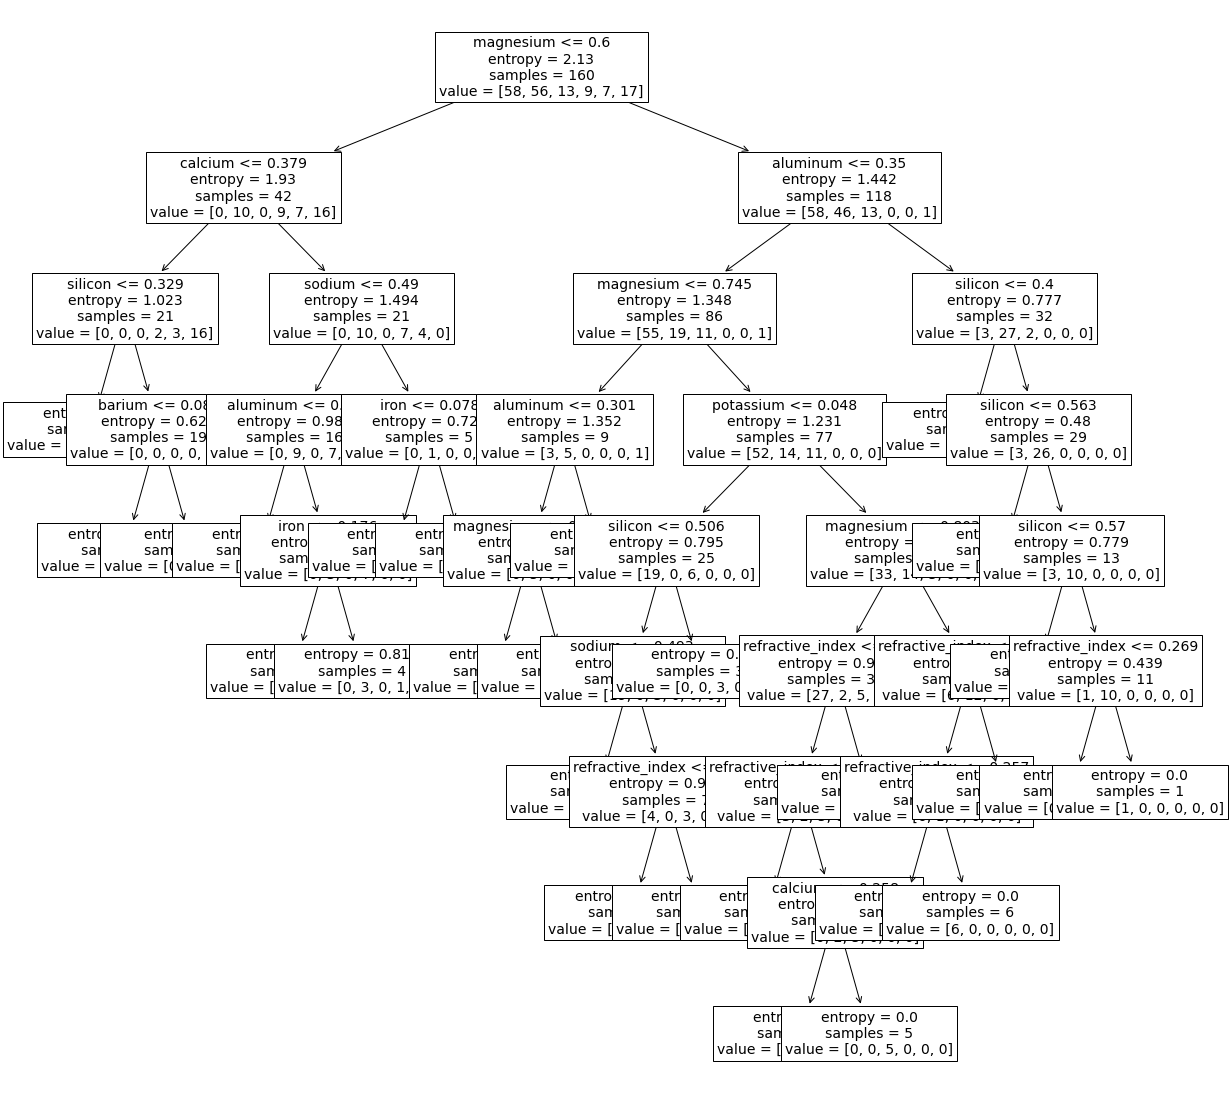

In [27]:
#Plotting our model
fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(model, feature_names=df.columns, fontsize=14)
plt.show()

Other metric we want to use is the roc curve. We can get much information by checking the progression of the true positives while the false positives increase. How does react our model as the classification threshold gets looser?

Plotting the ROC curve for each class

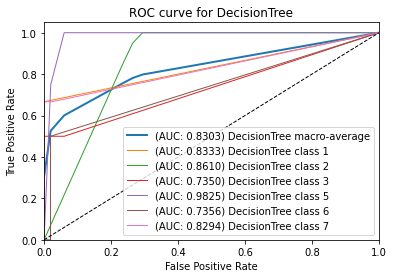

In [28]:
roc_summary(model, X_test, Y_test, 'DecisionTree macro-average')
class_name = list(set(Y_test[Y_test.columns[0]]))

for i in range(len(class_name)):
    roc_summary(model, X_test, Y_test, 'DecisionTree', i)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for DecisionTree")
plt.legend(loc="lower right")
plt.show()

### Bagging

In [29]:
np.random.seed(123)
model = DecisionTreeClassifier(criterion="entropy", max_depth=12, min_samples_split=5) 
bagging = BaggingClassifier(model, n_estimators=300, max_samples=0.8, max_features=0.7)

In [30]:
Y_train_1d = Y_train.to_numpy().ravel()
bagging.fit(X_train, Y_train_1d)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=12,
                                                        min_samples_split=5),
                  max_features=0.7, max_samples=0.8, n_estimators=300)

<b><u>Model evaluation</b></u>

In [31]:
Y_test_1d = Y_test.to_numpy().ravel()
bagging.score(X_test, Y_test_1d)

0.7592592592592593

In [32]:
balanced_accuracy_score(Y_test, bagging.predict(X_test))


0.6861111111111112

In [33]:
f1_score(Y_test, bagging.predict(X_test), average='micro')

0.7592592592592593

In [34]:
pd.DataFrame(metric_summary(bagging, X_test, Y_test, 'Bagging')).T

,roc_auc,f1_micro,balanced_accuracy
Bagging,0.9713,0.7593,0.6861


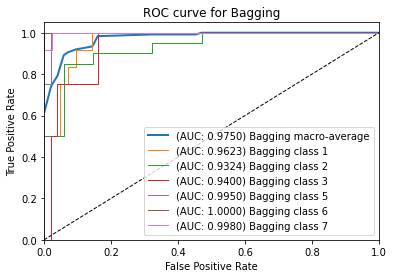

In [35]:
roc_summary(bagging, X_test, Y_test, 'Bagging macro-average')
for i in range(len(class_name)):
    roc_summary(bagging, X_test, Y_test, 'Bagging', i)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Bagging")
plt.legend(loc="lower right")
plt.show()

### RandomForest

In [36]:
np.random.seed(123)
rf = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=12, min_samples_split=5, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_samples=0.8)

In [37]:
rf.fit(X_train,Y_train_1d)

RandomForestClassifier(max_depth=12, max_samples=0.8, min_samples_split=5,
                       n_estimators=300)

<b><u>Model evaluation</b></u>

In [38]:
rf.score(X_test,Y_test_1d)

0.7592592592592593

In [39]:
balanced_accuracy_score(Y_test, rf.predict(X_test))

0.6166666666666667

In [40]:
f1_score(Y_test, rf.predict(X_test), average='micro')

0.7592592592592593

In [41]:
pd.DataFrame(metric_summary(rf, X_test, Y_test, 'RandomForest')).T

,roc_auc,f1_micro,balanced_accuracy
RandomForest,0.9732,0.7593,0.6167


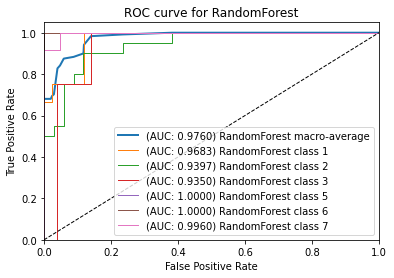

In [42]:
roc_summary(rf, X_test, Y_test, 'RandomForest macro-average')
for i in range(len(class_name)):
    roc_summary(rf, X_test, Y_test, 'RandomForest', i)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for RandomForest")
plt.legend(loc="lower right")
plt.show()

Conclusion: the Bagging technique slightly improved the performance of our base model. RandomForest improved it a little bit more. 

### Randomized Search

In [43]:
def grid_summary(model, X, y, param_grid, scoring='accuracy', cv=None, n_iter=10):
    '''Hyperparameters summary'''
    
    grid = RandomizedSearchCV(model, param_distributions=param_grid, scoring=scoring, cv=cv, n_iter=n_iter)
    grid = grid.fit(X, y)
    
    df = (pd.DataFrame(grid.cv_results_))
    df['mean_test_score'] = df['mean_test_score'].map('{:,.4f}'.format)
    df['std_test_score'] = df['std_test_score'].map('{:,.2f}'.format)    
    df[scoring] = df.apply(lambda x: str(x['mean_test_score'])+' \u00B1 '+str(x['std_test_score']), axis=1)
        
    df2 = df[['rank_test_score','params',scoring]]
    df2.columns = ['Rank', 'Hyperparameter optimization',scoring]
    return df2.sort_values(by='Rank').style.hide_index();

In [44]:
np.random.seed(123)

param_grid = [{'max_depth': [4, 6, 8, 10, 12],
               'max_samples': [0.4, 0.6, 0.8],
               'n_estimators':[100, 200, 300, 400],
               'criterion':['gini','entropy']}]

print('RandomForestClassifier')
grid_summary(RandomForestClassifier(), X_train, Y_train.to_numpy().ravel(), param_grid, scoring='f1_micro', n_iter=3, cv=KFold(5))

RandomForestClassifier


Rank,Hyperparameter optimization,f1_micro
1,"{'n_estimators': 200, 'max_samples': 0.8, 'max_depth': 12, 'criterion': 'entropy'}",0.7562 ± 0.05
2,"{'n_estimators': 100, 'max_samples': 0.6, 'max_depth': 4, 'criterion': 'gini'}",0.7063 ± 0.06
2,"{'n_estimators': 100, 'max_samples': 0.6, 'max_depth': 12, 'criterion': 'entropy'}",0.7063 ± 0.08


In [45]:
np.random.seed(123)

param_grid = [{'max_depth': [4, 6, 8, 10, 12],
               'criterion':['gini','entropy'],
               'min_samples_split':range(2,10)}]

print('DecisionTreeClassifier')
grid_summary(DecisionTreeClassifier(), X_train, Y_train.to_numpy().ravel(), param_grid, scoring='f1_micro',n_iter=3, cv=KFold(5))

DecisionTreeClassifier


Rank,Hyperparameter optimization,f1_micro
1,"{'min_samples_split': 5, 'max_depth': 8, 'criterion': 'entropy'}",0.6500 ± 0.08
2,"{'min_samples_split': 2, 'max_depth': 10, 'criterion': 'entropy'}",0.6438 ± 0.05
3,"{'min_samples_split': 4, 'max_depth': 8, 'criterion': 'entropy'}",0.6250 ± 0.06


## Metrics Summary

In [46]:
np.random.seed(123)

rf_h = RandomForestClassifier(n_estimators=200, max_samples=0.8, max_depth=12, criterion='entropy').fit(X_train, Y_train.to_numpy().ravel())
dt_h = DecisionTreeClassifier(max_depth=8, criterion='entropy', min_samples_split=5).fit(X_train, Y_train)

model.fit(X_train, Y_train)

pd.concat([
    metric_summary(rf_h, X_test, Y_test, 'RandomForest (tuning)'),
    metric_summary(dt_h, X_test, Y_test, 'DecisionTree (tuning)'),
    metric_summary(bagging, X_test, Y_test, 'Bagging'),
    metric_summary(rf, X_test, Y_test, 'RandomForest (base)'),
    metric_summary(model, X_test, Y_test,'DecisionTree (base)')], axis=1).T

,roc_auc,f1_micro,balanced_accuracy
RandomForest (tuning),0.9783,0.7593,0.6861
DecisionTree (tuning),0.8229,0.7222,0.6500
Bagging,0.9713,0.7593,0.6861
RandomForest (base),0.9732,0.7593,0.6167
DecisionTree (base),0.8202,0.7037,0.6361


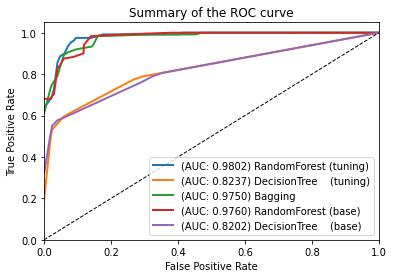

In [47]:
roc_summary(rf_h, X_test, Y_test, 'RandomForest (tuning)')
roc_summary(dt_h, X_test, Y_test, 'DecisionTree    (tuning)')
roc_summary(bagging, X_test, Y_test, 'Bagging')
roc_summary(rf, X_test, Y_test, 'RandomForest (base)')
roc_summary(model, X_test, Y_test, 'DecisionTree    (base)')

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Summary of the ROC curve")
plt.legend(loc="lower right")
plt.show()